In [130]:
from pyspark.sql import SparkSession

MAX_MEMORY = "5g"
spark = SparkSession.builder.master("local")\
                    .appName("ml_taix")\
                    .config("spark.excutor.memory", MAX_MEMORY)\
                    .config("spark.driver.memory", MAX_MEMORY).getOrCreate()

In [141]:
from typing import List, Optional
import os

directory: str = [f"{os.getcwd()}/data/{i}" for i in os.listdir(f"{os.getcwd()}/data")][2]
filename: List[str] = [f"{directory}/{data}" for data in os.listdir(directory)]
filename.sort()

In [174]:
import matplotlib.pyplot as plt 
import seaborn as sns 

def year_read_data() -> List:
    return [spark.read.parquet(f"file:///{data}") for data in filename]

def year_data_topandas_transform(table_name: str, qs: str) -> List[SparkSession]:
    t_pickup_dat = []
    for data in year_read_data():
        data.createOrReplaceTempView(table_name)
        td = spark.sql(qs).toPandas()
        t_pickup_dat.append(td)
    return t_pickup_dat

def barplot_3to4_visualization(x: str, y: str, data: List, n_rows: int = 3, n_cols: int = 4) -> None:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 10))
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    fig.set_size_inches((80, 20))

    for i, axi in enumerate(ax.flat):
        sns.barplot(x=x, y=y, data=data[i], ax=axi)
        axi.set_title(f'taxi 2020 --> date {i+1}')
        axi.set_xticklabels(axi.get_xticklabels(), rotation=30)

    # 데이터 플롯 출력
    plt.show()

In [143]:
qs_2020 = """
SELECT 
    date,
    count(*) as pickup
FROM
    (SELECT 
        split(pickup_datetime, " ")[0] as date
    FROM 
        trips    
    )
GROUP BY 
    date
ORDER BY 
    date
"""
data2020_all = year_data_topandas_transform(table_name="trips", qs=qs_2020)

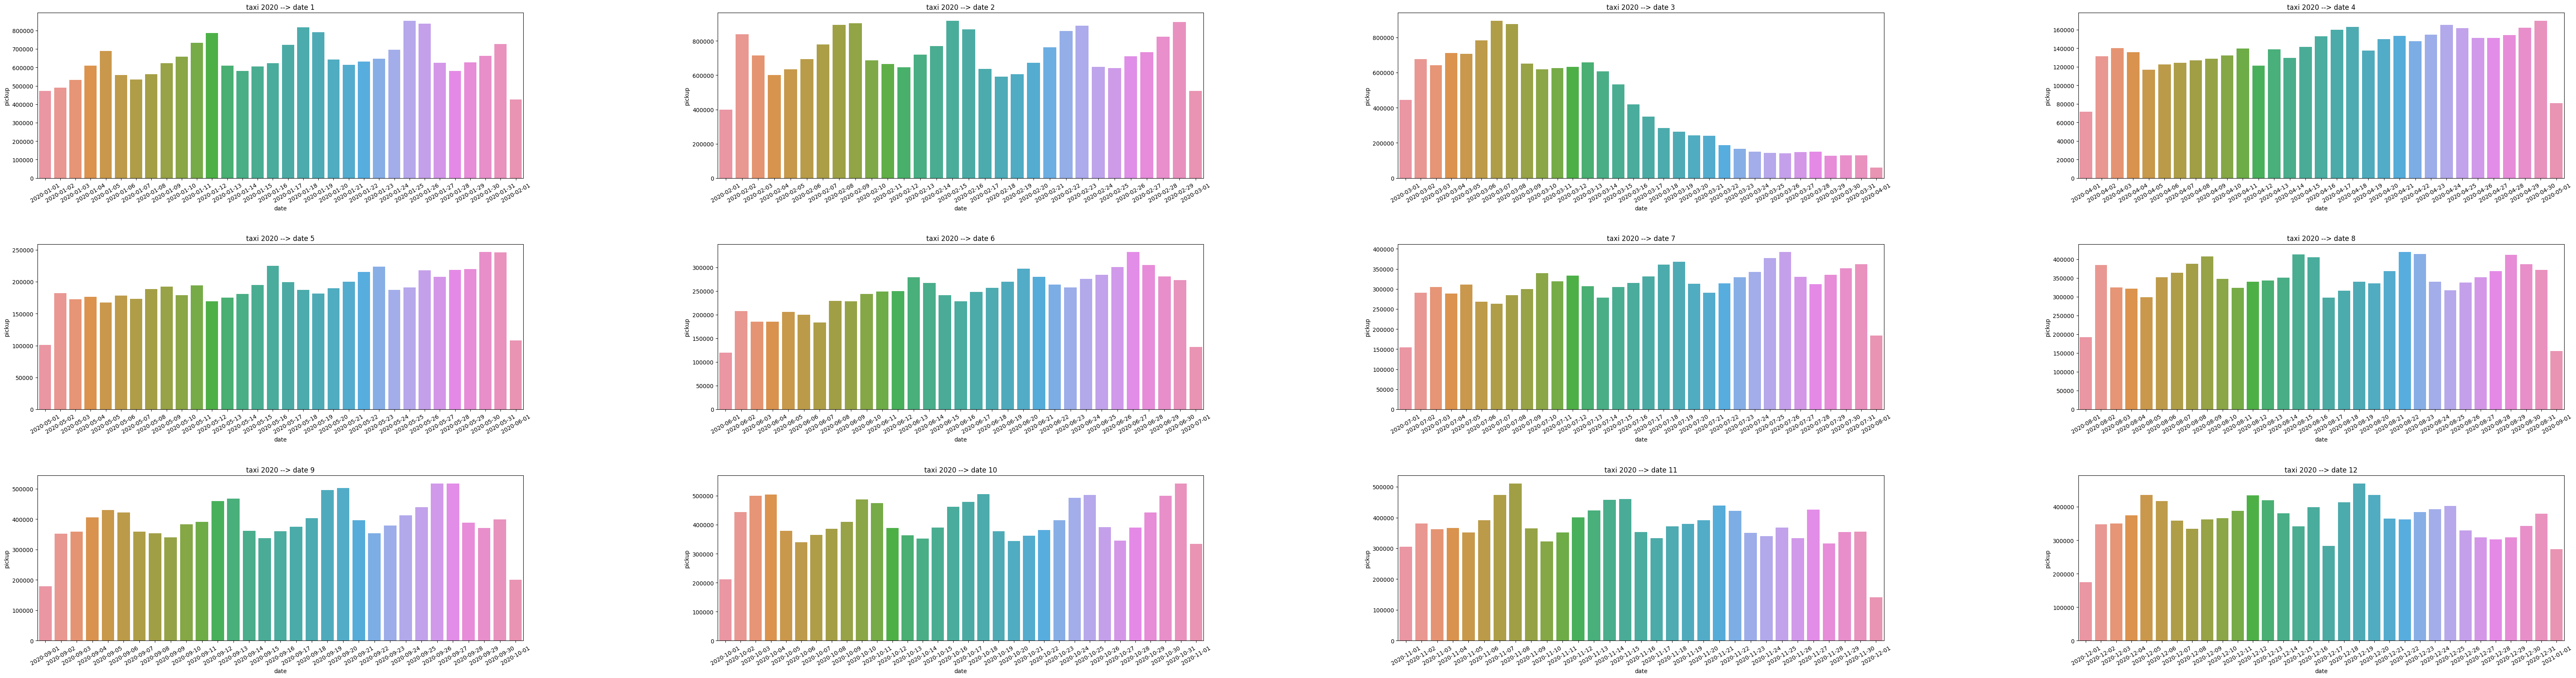

In [176]:
barplot_3to4_visualization(x="date", y="pickup", data=data2020_all)

In [238]:
qs = """
SELECT 
    TO_DATE(pickup_datetime) as date,
    AVG(trip_miles) as trip_miles, 
    CAST(AVG(trip_time) as INTEGER) as trip_time, 
    CAST(AVG(base_passenger_fare) as INTEGER) as base_passenger_fare,
    AVG(tips) as tips, 
    AVG(driver_pay) as driver_pay,
    COUNT(split(pickup_datetime, " ")[0]) as pickup_datetime
FROM 
    trips
GROUP BY 
    date
ORDER BY
    date
"""
w_3to4 = year_data_topandas_transform(table_name="trips", qs=qs)

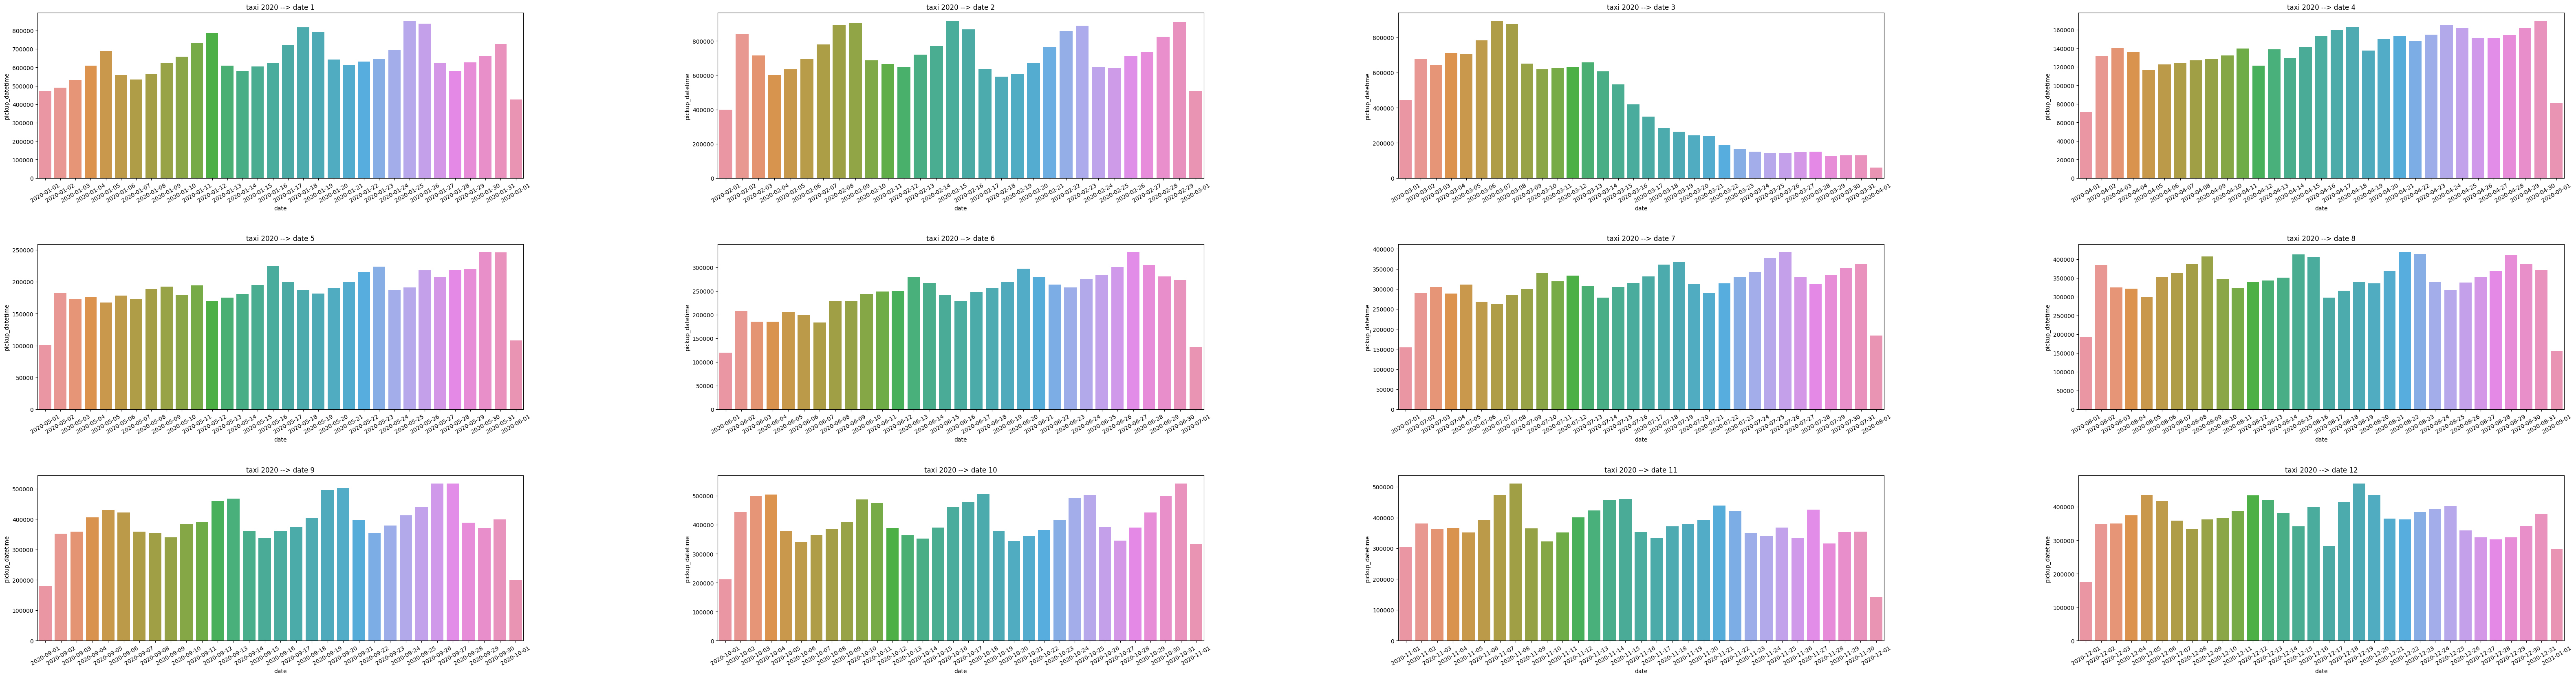

In [200]:
barplot_3to4_visualization(x="date", y="pickup_datetime", data=w_3to4)

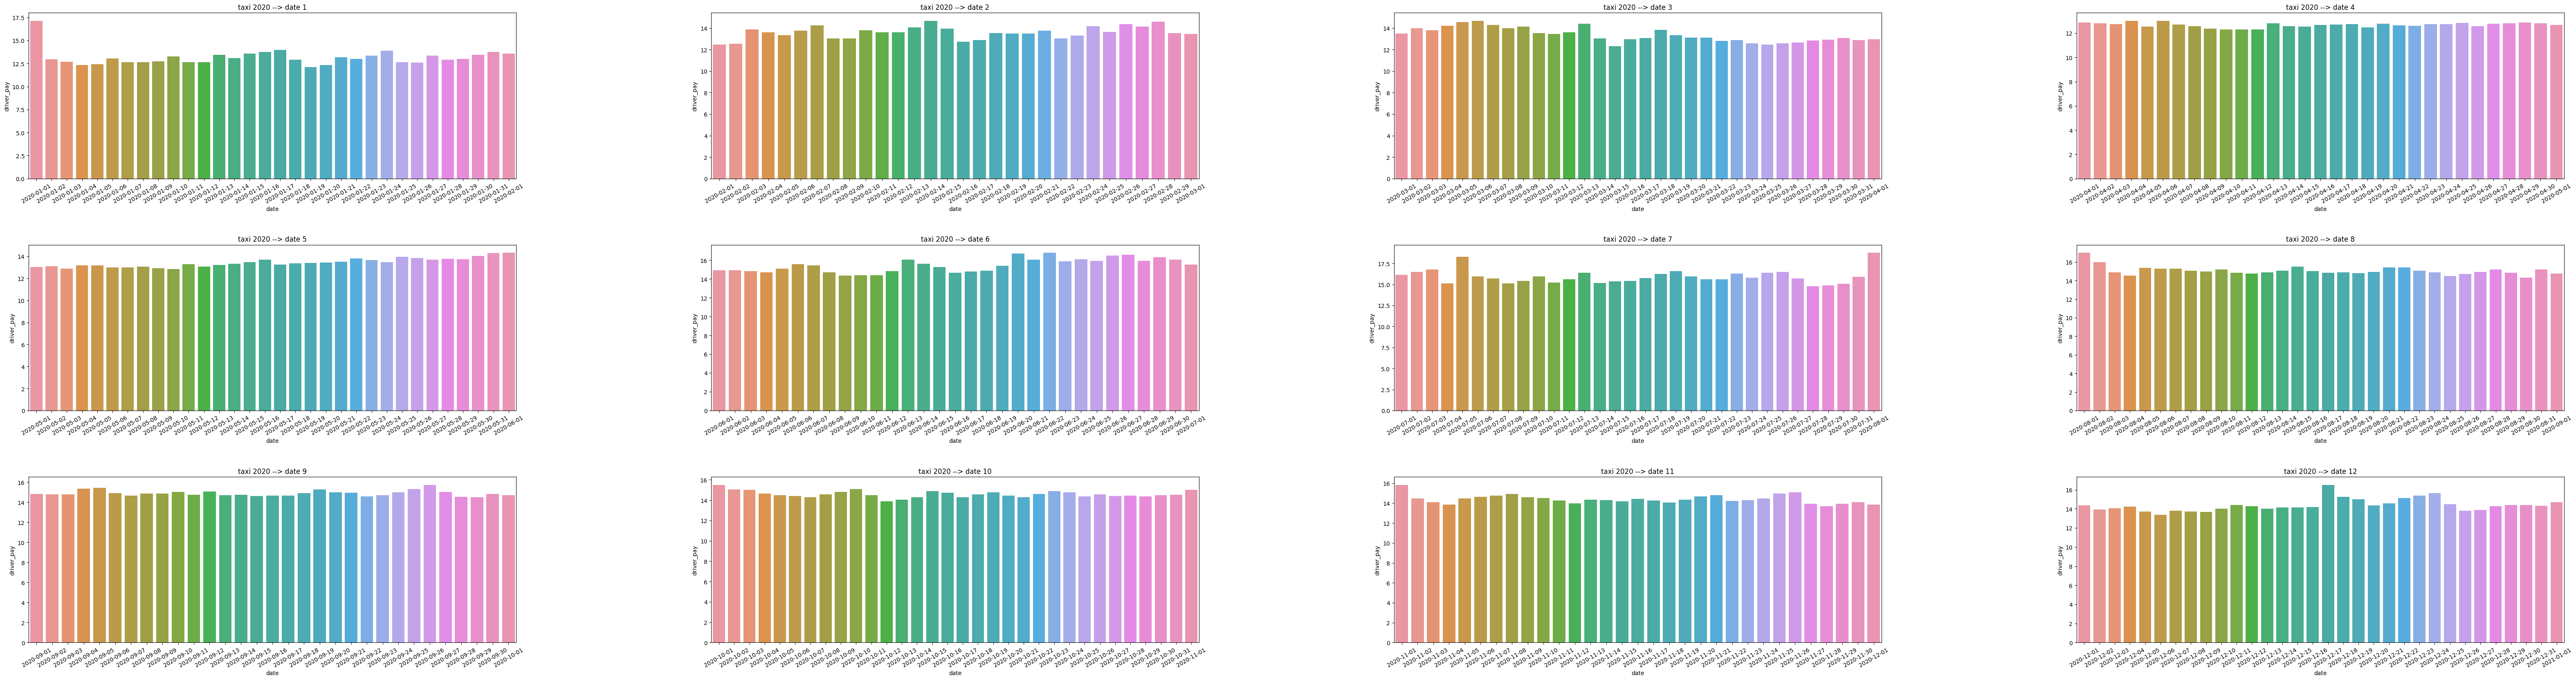

In [326]:
barplot_3to4_visualization(x="date", y="driver_pay", data=w_3to4)

In [357]:
qs = """
SELECT 
    TO_DATE(pickup_datetime) as pickup_datetime,
    trip_miles as trip_miles, 
    trip_time as trip_time, 
    base_passenger_fare,
    tips,
    driver_pay
FROM 
    trips
"""
spark.sql(qs).describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+
|summary|        trip_miles|         trip_time|base_passenger_fare|              tips|        driver_pay|
+-------+------------------+------------------+-------------------+------------------+------------------+
|  count|          11637123|          11637123|           11637123|          11637123|          11637123|
|   mean|4.5034525063459085|1011.9422130366759|  17.65629239363479| 0.510227722094494|14.372110674666525|
| stddev| 5.032814497036389| 682.8166499120199| 13.839165690906032|1.8558190247778088|11.558114152986922|
|    min|               0.0|                 0|            -115.85|               0.0|            -14.78|
|    max|            400.36|             52219|            2233.31|             470.0|           1607.98|
+-------+------------------+------------------+-------------------+------------------+------------------+



In [342]:
qs = """
SELECT 
    TO_DATE(pickup_datetime) as pickup_datetime,
    trip_miles as trip_miles, 
    trip_time as trip_time, 
    base_passenger_fare,
    tips,
    driver_pay
FROM 
    trips
WHERE 
    base_passenger_fare BETWEEN 1 AND 30
    AND trip_miles BETWEEN 1 AND 47
    AND trip_time > 0
    AND tips BETWEEN 2 AND 100
    AND driver_pay BETWEEN 5 AND 500
"""
data = spark.sql(qs)
data.createOrReplaceTempView("data")

In [345]:
qs = """
SELECT 
    TO_DATE(pickup_datetime) as date,
    AVG(trip_miles) as trip_miles, 
    CAST(AVG(trip_time) as INTEGER) as trip_time, 
    CAST(AVG(base_passenger_fare) as INTEGER) as base_passenger_fare,
    AVG(tips) as tips, 
    AVG(driver_pay) as driver_pay,
    COUNT(split(pickup_datetime, " ")[0]) as pickup_datetime
FROM 
    data
GROUP BY 
    date
ORDER BY
    date
"""
preprocessing_3_to_4 = year_data_topandas_transform(table_name="data", qs=qs)

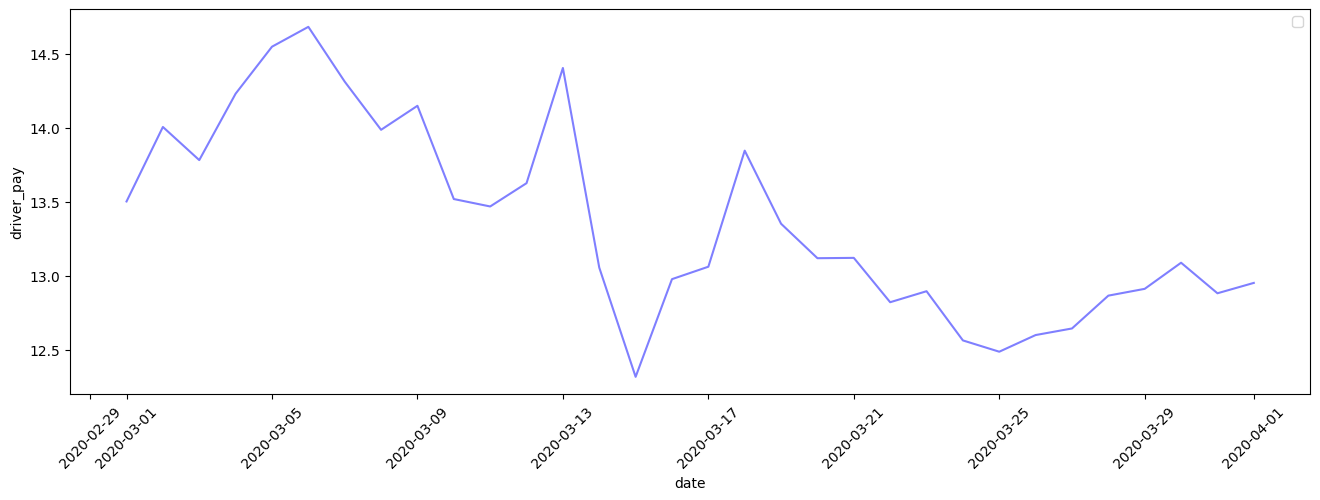

In [351]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(x="date", y="driver_pay", data=preprocessing_3_to_4[2], alpha=0.5,  color="blue")

plt.xticks(rotation=45)
plt.legend()
plt.show()

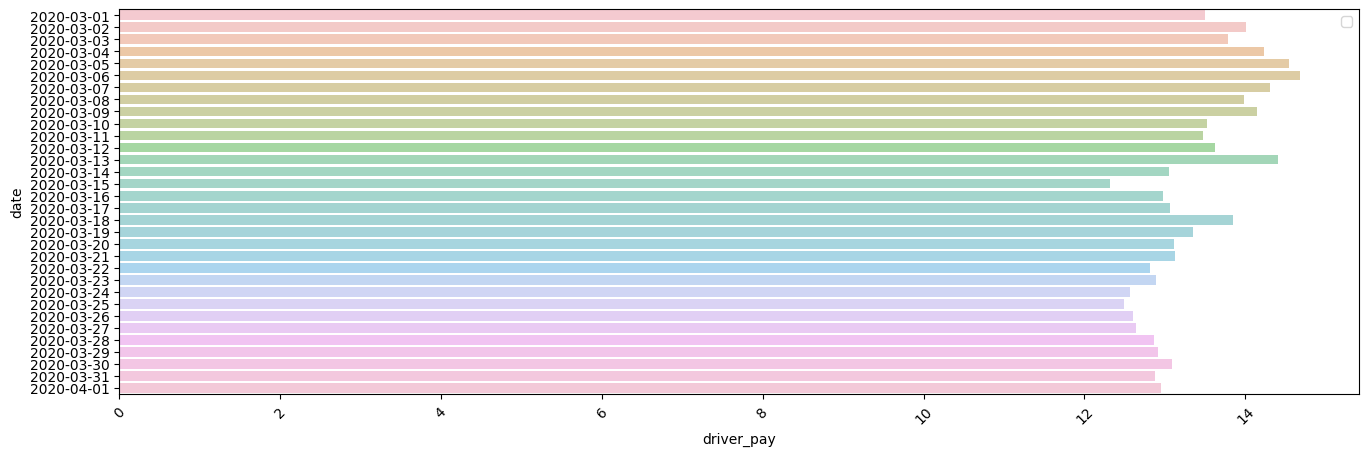

In [358]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x="driver_pay", y="date", data=preprocessing_3_to_4[2], alpha=0.5)

plt.xticks(rotation=45)
plt.legend()
plt.show()

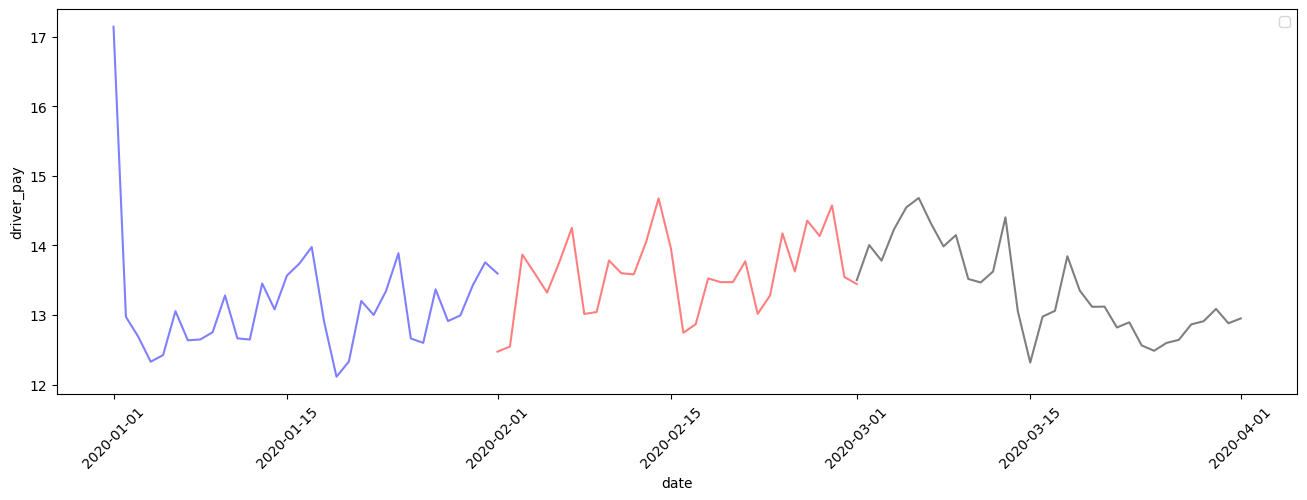

In [359]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(x="date", y="driver_pay", data=preprocessing_3_to_4[0], alpha=0.5,  color="blue")
sns.lineplot(x="date", y="driver_pay", data=preprocessing_3_to_4[1], alpha=0.5,  color="red")
sns.lineplot(x="date", y="driver_pay", data=preprocessing_3_to_4[2], alpha=0.5,  color="black")

plt.xticks(rotation=45)
plt.legend()
plt.show()

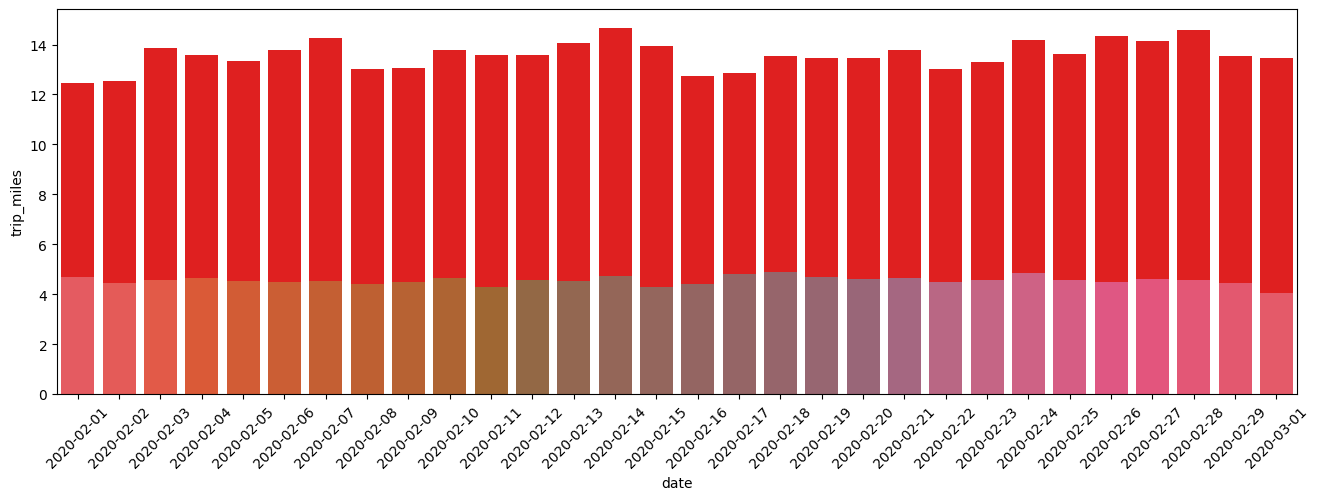

In [373]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x="date", y="driver_pay", data=preprocessing_3_to_4[1])
sns.barplot(x="date", y="trip_miles", data=preprocessing_3_to_4[1], color="red")
plt.xticks(rotation=45)
plt.show()